In [255]:
import numpy as np
from scipy.linalg import subspace_angles
from numpy import linalg as LA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from igPCA.igPCA import igPCA
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from igPCA.GMD import GMD
from sklearn.metrics import f1_score
from sklearn import metrics

In [224]:
# setting info
r1 = 12
r2 = 10

In [226]:
def read_data(filename, ncols=None):
    if ncols == None:
        with open(filename) as f:
            ncols = len(f.readline().split(','))
    data = np.loadtxt(filename, delimiter=',',
                      skiprows=1, usecols=range(1, ncols))
    return data

def normalize_matrix(H):
    t = np.trace(H)
    n = np.shape(H)[0]
    H = H/t*n
    return H

In [ ]:
# read data
description = pd.read_csv('../real/nf.description.csv', index_col=0)
taxa = pd.read_csv('../real.nf/taxa.csv', index_col=0)

Q2 = read_data('../real.nf/Q2.csv', None)
H = read_data('.../real.nf/unifrac.csv', None)
Q1 = read_data('../real.nf/Q1.csv', None)
X1 = read_data('../real.nf/X1.csv', None)
X2 = read_data('../real.nf/X2.csv', 120)

In [227]:
# categories
description['classification'] = description['diet'].values == 'Breast milk'
description['classification'] = description['classification'].astype('category')
description['classification'] = description['classification'].cat.rename_categories(['Formula Feed', 'Breast Feed'])

H = normalize_matrix(H)
Q1 = normalize_matrix(Q1)
Q2 = normalize_matrix(Q2)
n, p1 = np.shape(X1)
_, p2 = np.shape(X2)

In [228]:
# init models
model1 = igPCA(X1, X2, H, Q1, Q2, r1, r2)
model2 = igPCA(X1, X2, np.eye(n), np.eye(p1), np.eye(p2), r1,r2)
model3 = igPCA(X1, X2, np.eye(n), np.eye(p1), np.eye(p2), r1,r2) #use the same joint rank as igPCA
model4 = igPCA(X1, X2, np.eye(n), np.eye(p1), np.eye(p2), r1,r2) #use joint rank = 2
model5 = GMD(X1, H, Q1, r1)
model6 = GMD(X2, H, Q2, r2)

In [229]:
# fit GMD
model4.fit(r0=2, thres=None)
model5.fit()
model6.fit()

## joint rank selection

In [230]:
def compute_drop(s):
    n = len(s) - 1
    diff = [s[i-1]-s[i] for i in range(1, n+1)]
    cutoff = np.argmax(np.array(diff))
    break_point = s[cutoff]
    dis = (s[cutoff] - s[cutoff+1])/10
    return ((break_point-dis, cutoff))

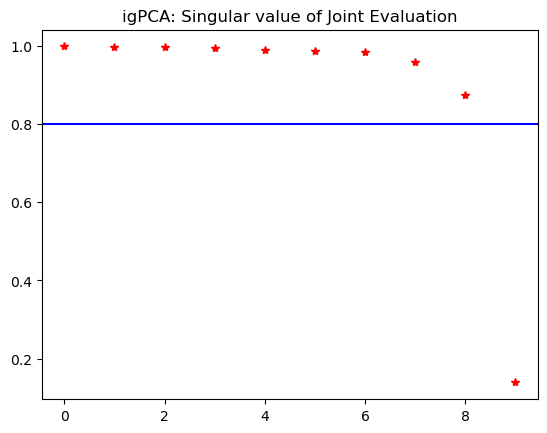

In [254]:
U1, U2, X_1_tilde, X_2_tilde = model1.__joint_ingredient__()
joint_prod = model1.__H_inner_prod__(U1, U2)
_, s, _ = LA.svd(joint_prod, full_matrices=False, compute_uv=True)
plt.plot(s, 'r*')
plt.axhline(compute_drop(s)[0], color = 'b', linestyle = '-') 
plt.title("igPCA: Singular value of Joint Evaluation")
plt.show()
# fit integrative models
model1.fit(r0=compute_drop(s)[1]+1, thres=None)

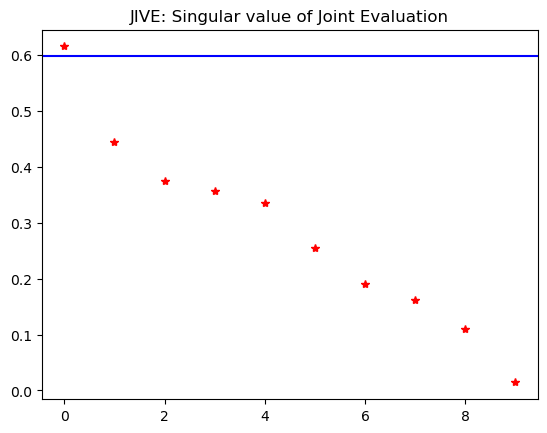

In [232]:
U1, U2, X_1_tilde, X_2_tilde = model2.__joint_ingredient__()
joint_prod = model2.__H_inner_prod__(U1, U2)
_, s, _ = LA.svd(joint_prod, full_matrices=False, compute_uv=True)
plt.plot(s, 'r*')
plt.axhline(y = compute_drop(s)[0], color = 'b', linestyle = '-') 
plt.title("JIVE: Singular value of Joint Evaluation")
plt.show()
# fit model
model2.fit(r0=compute_drop(s)[1]+1, thres=None)

In [233]:
# fit model 3
model3.fit(r0=model1.r0, thres=None)

# Visualization

## Heatmap of Low Rank Structure

Inspired by JIVE paper

In [234]:
def heatmap_low_rank(model):
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    plt.tight_layout(h_pad=2)
    sns.heatmap(model.X1, ax=axes[0, 0], cbar=False, cmap=sns.color_palette("vlag", as_cmap=True),mask=(model.X1==0))
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_ylabel('')
    axes[0, 0].set_title('X1')
    sns.heatmap(model.J1_hat, ax=axes[0, 1], cbar=False, cmap=sns.color_palette("vlag", as_cmap=True),mask=(model.J1_hat==0))
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('')
    axes[0, 1].set_title('J1')
    sns.heatmap(model.A1_hat, ax=axes[0, 2], cbar=False, cmap=sns.color_palette("vlag", as_cmap=True),mask=(model.A1_hat==0))
    axes[0, 2].set_xlabel('')
    axes[0, 2].set_ylabel('')
    axes[0, 2].set_title('A1')
    sns.heatmap(model.X1-model.X_1_hat, ax=axes[0, 3], cbar=False, cmap=sns.color_palette("vlag", as_cmap=True),mask=(model.X1-model.X_1_hat==0))
    axes[0, 3].set_xlabel('')
    axes[0, 3].set_ylabel('')
    axes[0, 3].set_title('Noise')
    sns.heatmap(model.X2, ax=axes[1,0], cbar=False, cmap=sns.color_palette("vlag", as_cmap=True),mask=(model.X2==0))
    axes[1, 0].set_xlabel('')
    axes[1, 0].set_ylabel('')
    axes[1, 0].set_title('X2')
    sns.heatmap(model.J2_hat, ax=axes[1,1], cbar=False, cmap=sns.color_palette("vlag", as_cmap=True),mask=(model.J2_hat==0))
    axes[1, 1].set_xlabel('')
    axes[1, 1].set_ylabel('')
    axes[1, 1].set_title('J2')
    sns.heatmap(model.A2_hat, ax=axes[1, 2], cbar=False, cmap=sns.color_palette("vlag", as_cmap=True),mask=(model.A2_hat==0))
    axes[1, 2].set_xlabel('')
    axes[1, 2].set_ylabel('')
    axes[1, 2].set_title('A2')
    sns.heatmap(model.X2-model.X_2_hat, ax=axes[1,3], cbar=False, cmap=sns.color_palette("vlag", as_cmap=True),mask=(model.X2-model.X_2_hat==0))
    axes[1, 3].set_xlabel('')
    axes[1, 3].set_ylabel('')
    axes[1, 3].set_title('Noise')

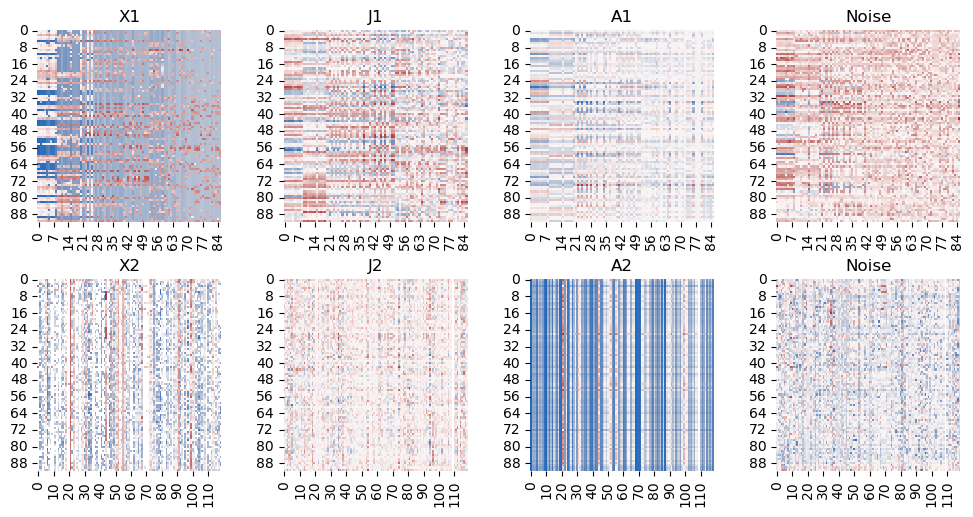

In [235]:
# igPCA, more positive components compared with JIVE
heatmap_low_rank(model1)

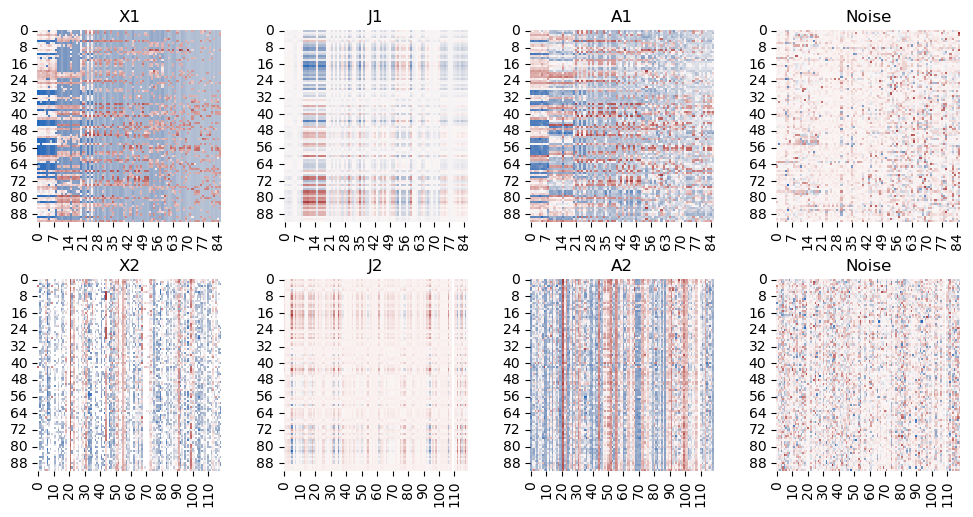

In [236]:
# JIVE 1
heatmap_low_rank(model2)

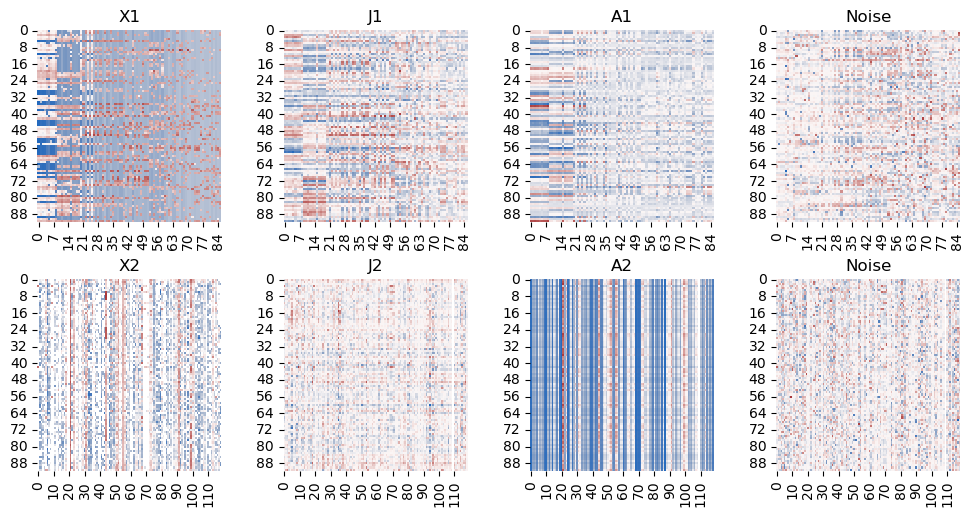

In [237]:
#JIVE 2
heatmap_low_rank(model3)

## Variation Explained

In [238]:
def compute_QH_norm(H, Q, A):
    numeric_1 = np.matmul(H, A)
    numeric_2 = np.matmul(Q, np.transpose(A))
    result = np.trace(np.matmul(numeric_1, numeric_2))
    return (result)

def var_ingredient_x1(model):
    def variation(model, U, D, V):
        var_explained = [compute_QH_norm(model.H, model.Q1, U[:,i-1:i]*D[i-1:i]*V[:,i-1:i].T) for i in range(1, model.r1+1)]
        var_explained = var_explained + [compute_QH_norm(model.H, model.Q1, model.X1 - model.X_1_hat)]
        var_explained = var_explained/compute_QH_norm(model.H, model.Q1, model.X1)
        return(var_explained)
    D = np.concatenate((model.D01, model.D11))
    index_sort = np.argsort(D)[::-1]
    label_belonging = np.multiply((index_sort) < model.r0,1)
    label = ['joint' * i + 'individual'*(1-i) for i in label_belonging] + ['noise']
    label_color = ['tab:red' * i + 'tab:blue'*(1-i) for i in label_belonging] + ['tab:orange']
    D = D[index_sort]
    U = np.concatenate((model.U0, model.U1), axis = 1)[:,index_sort]
    V = np.concatenate((model.V01, model.V11), axis = 1)[:,index_sort]
    var_explained = variation(model, U, D, V)
    return(label_color, label, var_explained, U, V)

def var_ingredient_x2(model):
    def variation(model, U, D, V):
        var_explained = [compute_QH_norm(model.H, model.Q2, U[:,i-1:i]*D[i-1:i]*V[:,i-1:i].T) for i in range(1, model.r2+1)]
        var_explained = var_explained + [compute_QH_norm(model.H, model.Q2, model.X2 - model.X_2_hat)]
        var_explained = var_explained/compute_QH_norm(model.H, model.Q2, model.X2)
        return(var_explained)
    D = np.concatenate((model.D02, model.D12))
    index_sort = np.argsort(D)[::-1]
    label_belonging = np.multiply((index_sort) < model.r0,1)
    label = ['joint' * i + 'individual'*(1-i) for i in label_belonging] + ['noise']
    label_color = ['tab:red' * i + 'tab:blue'*(1-i) for i in label_belonging] + ['tab:orange']
    D = D[index_sort]
    U = np.concatenate((model.U0, model.U2), axis = 1)[:,index_sort]
    V = np.concatenate((model.V02, model.V12), axis = 1)[:,index_sort]
    var_explained = variation(model, U, D, V)
    return(label_color, label, var_explained, U, V)

In [239]:
def total_variation_explained(label, var_explained):
    label = np.array(label)
    joint = sum(var_explained[label == 'joint'])
    individual = sum(var_explained[label == 'individual'])
    noise = sum(var_explained[label == 'noise'])
    return((joint, individual, noise))

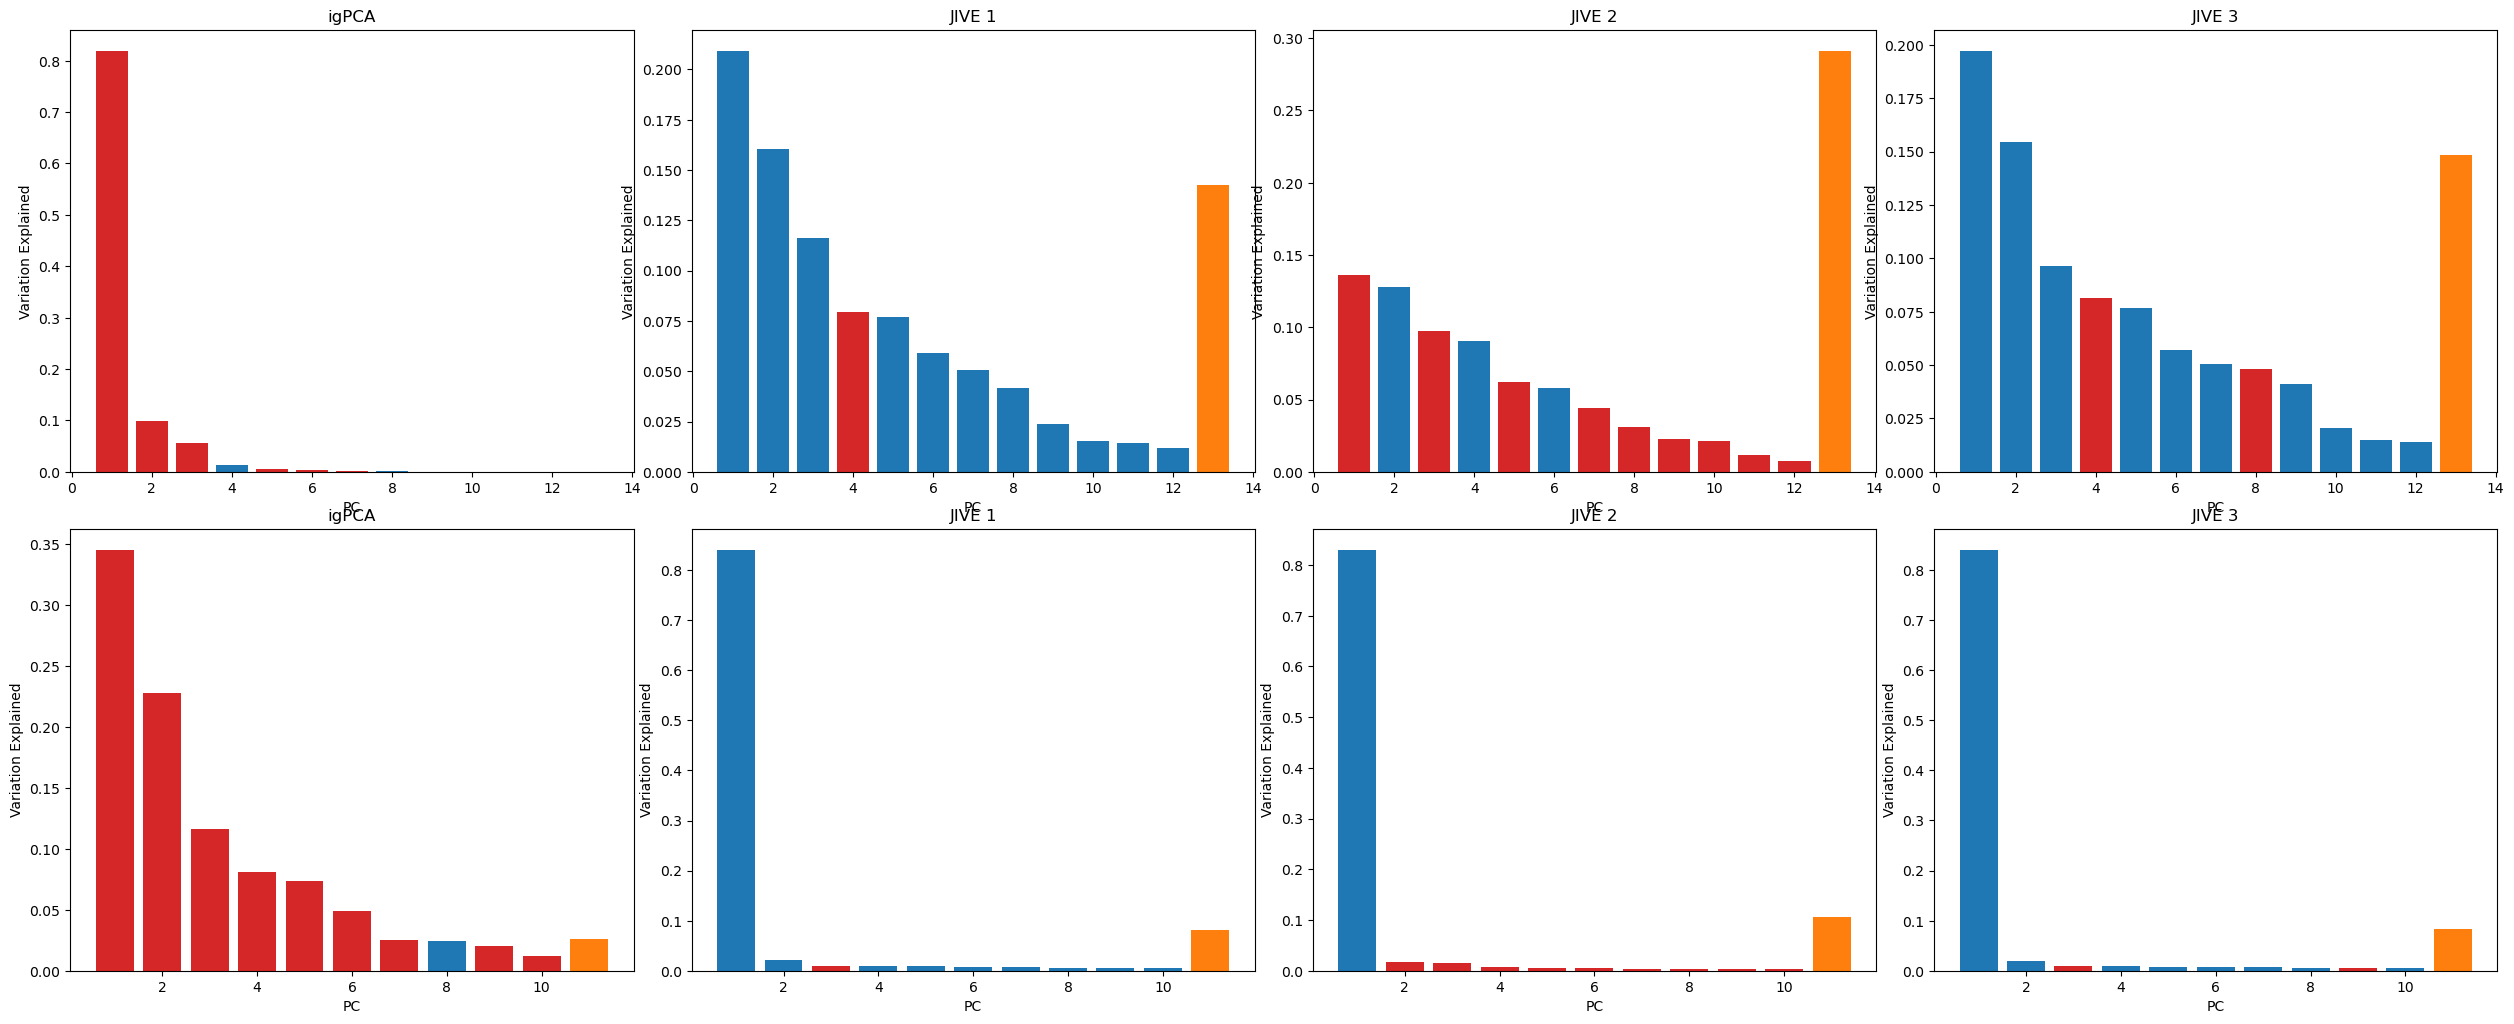

In [240]:
fig, axes = plt.subplots(2, 4, figsize=(25, 10))
plt.tight_layout(h_pad=2)
axes[0, 0].bar(np.arange(1, model1.r1+2), var_ingredient_x1(model1)[2], color=var_ingredient_x1(model1)[0])
axes[0, 0].set_xlabel('PC')
axes[0, 0].set_ylabel('Variation Explained')
axes[0, 0].set_title('igPCA')
axes[0, 1].bar(np.arange(1, model1.r1+2), var_ingredient_x1(model2)[2], color=var_ingredient_x1(model2)[0])
axes[0, 1].set_xlabel('PC')
axes[0, 1].set_ylabel('Variation Explained')
axes[0, 1].set_title('JIVE 1')
axes[0, 2].bar(np.arange(1, model1.r1+2), var_ingredient_x1(model3)[2], color=var_ingredient_x1(model3)[0])
axes[0, 2].set_xlabel('PC')
axes[0, 2].set_ylabel('Variation Explained')
axes[0, 2].set_title('JIVE 2')
axes[0, 3].bar(np.arange(1, model1.r1+2), var_ingredient_x1(model4)[2], color=var_ingredient_x1(model4)[0])
axes[0, 3].set_xlabel('PC')
axes[0, 3].set_ylabel('Variation Explained')
axes[0, 3].set_title('JIVE 3')
axes[1, 0].bar(np.arange(1, model1.r2+2), var_ingredient_x2(model1)[2], color=var_ingredient_x2(model1)[0])
axes[1, 0].set_xlabel('PC')
axes[1, 0].set_ylabel('Variation Explained')
axes[1, 0].set_title('igPCA')
axes[1, 1].bar(np.arange(1, model1.r2+2), var_ingredient_x2(model2)[2], color=var_ingredient_x2(model2)[0])
axes[1, 1].set_xlabel('PC')
axes[1, 1].set_ylabel('Variation Explained')
axes[1, 1].set_title('JIVE 1')
axes[1, 2].bar(np.arange(1, model1.r2+2), var_ingredient_x2(model3)[2], color=var_ingredient_x2(model3)[0])
axes[1, 2].set_xlabel('PC')
axes[1, 2].set_ylabel('Variation Explained')
axes[1, 2].set_title('JIVE 2')
axes[1, 3].bar(np.arange(1, model1.r2+2), var_ingredient_x2(model4)[2], color=var_ingredient_x2(model4)[0])
axes[1, 3].set_xlabel('PC')
axes[1, 3].set_ylabel('Variation Explained')
axes[1, 3].set_title('JIVE 3')
plt.show()

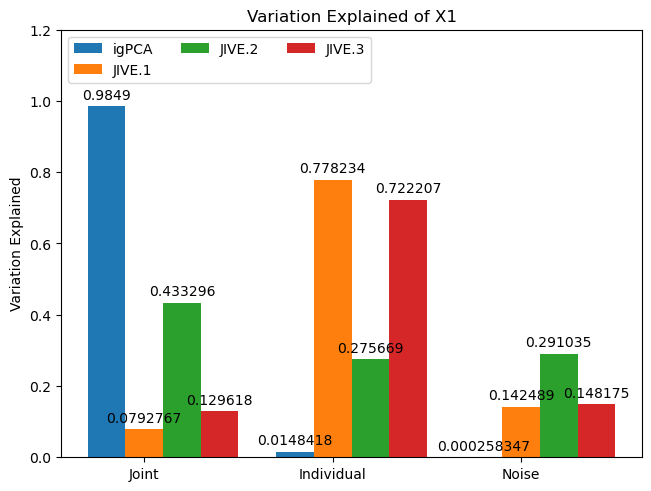

In [241]:
species = ("Joint", "Individual", "Noise")
penguin_means = {
    'igPCA':  total_variation_explained(var_ingredient_x1(model1)[1], var_ingredient_x1(model1)[2]),
    'JIVE.1': total_variation_explained(var_ingredient_x1(model2)[1], var_ingredient_x1(model2)[2]),
    'JIVE.2': total_variation_explained(var_ingredient_x1(model3)[1], var_ingredient_x1(model3)[2]),
    'JIVE.3': total_variation_explained(var_ingredient_x1(model4)[1], var_ingredient_x1(model4)[2]),
}

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Variation Explained')
ax.set_title('Variation Explained of X1')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)

plt.show()

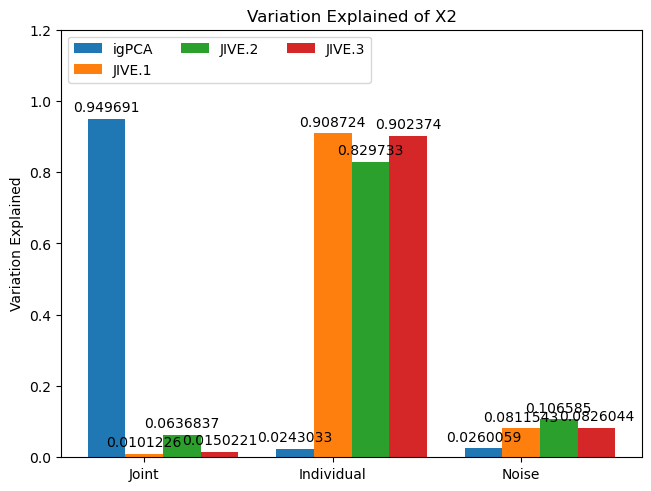

In [242]:
species = ("Joint", "Individual", "Noise")
penguin_means = {
    'igPCA':  total_variation_explained(var_ingredient_x2(model1)[1], var_ingredient_x2(model1)[2]),
    'JIVE.1': total_variation_explained(var_ingredient_x2(model2)[1], var_ingredient_x2(model2)[2]),
    'JIVE.2': total_variation_explained(var_ingredient_x2(model3)[1], var_ingredient_x2(model3)[2]),
    'JIVE.3': total_variation_explained(var_ingredient_x2(model4)[1], var_ingredient_x2(model4)[2]),
}

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Variation Explained')
ax.set_title('Variation Explained of X2')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)

plt.show()

## Sample Score

In [243]:
def first_two_pc_x1(model):
    score = np.concatenate([var_ingredient_x1(model)[3][:,0:1], var_ingredient_x1(model)[3][:,1:2]], axis=1)
    to_plot = pd.DataFrame(score, columns = ['PC1','PC2'], index = description.index)
    to_plot['diet'] = description['classification']
    return(to_plot)

def first_two_pc_x2(model):
    score = np.concatenate([var_ingredient_x2(model)[3][:,0:1], var_ingredient_x2(model)[3][:,1:2]], axis=1)
    to_plot = pd.DataFrame(score, columns = ['PC1','PC2'], index = description.index)
    to_plot['diet'] = description['classification']
    return(to_plot)

def first_two_joint_pc(model):
    if model.r0 == 1:
        score = model.U0[:,:1].reshape(-1,1)
        to_plot = pd.DataFrame(score, columns = ['PC1'], index = description.index)
    else:
        score = np.concatenate([model.U0[:,:1].reshape(-1,1), model.U0[:,1:2].reshape(-1,1)], axis=1)
        to_plot = pd.DataFrame(score, columns = ['PC1','PC2'], index = description.index)
    to_plot['diet'] = description['classification']
    return(to_plot)

/var/folders/7j/nhzytlhx5qd4n0cz79hdk2zr0000gn/T/ipykernel_30137/1151814503.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


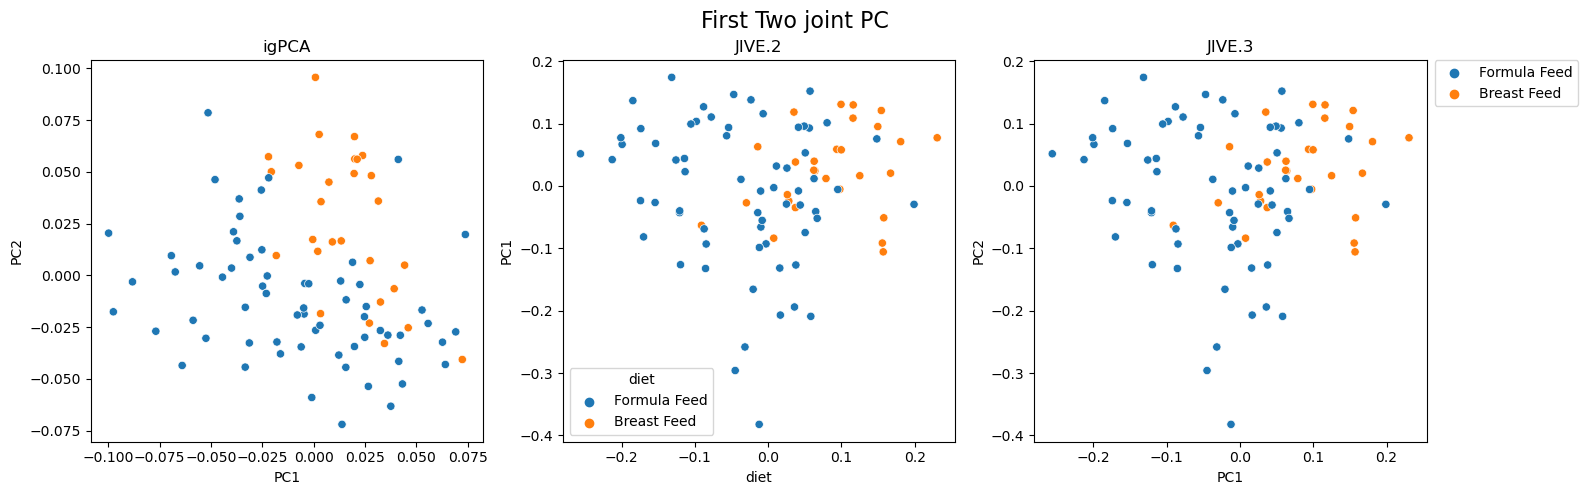

In [244]:
# first two joint PC
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
plt.tight_layout(h_pad=2)
sns.scatterplot(data=first_two_joint_pc(model1), x="PC1", y="PC2", hue = "diet", ax=axes[0])
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('igPCA')
axes[0].get_legend().set_visible(False)
sns.scatterplot(data=first_two_joint_pc(model3), x="PC1", y="PC2", hue = "diet", ax=axes[1])
axes[1].set_xlabel('diet')
axes[1].set_ylabel('PC1')
axes[1].set_title('JIVE.2')
sns.scatterplot(data=first_two_joint_pc(model4), x="PC1", y="PC2", hue = "diet", ax=axes[2])
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].set_title('JIVE.3')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.suptitle("First Two joint PC", size = 16)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

/var/folders/7j/nhzytlhx5qd4n0cz79hdk2zr0000gn/T/ipykernel_30137/738921140.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


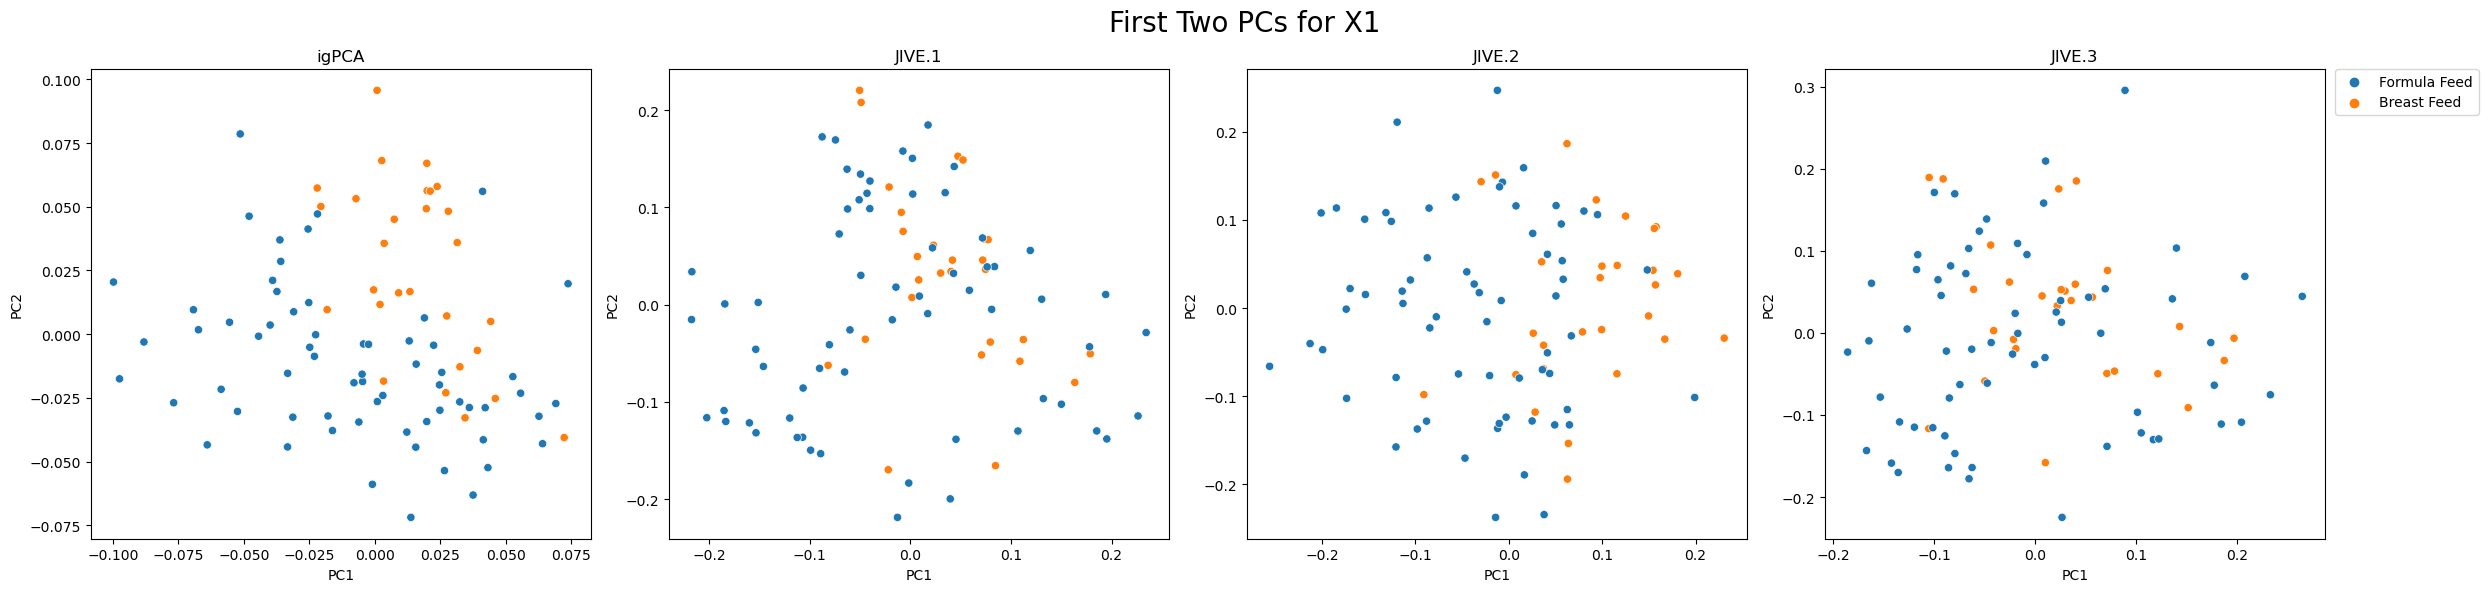

In [245]:
# first two PC of X1
fig, axes = plt.subplots(1, 4, figsize=(25, 6))
plt.tight_layout(h_pad=2)
sns.scatterplot(data=first_two_pc_x1(model1), x="PC1", y="PC2", hue = "diet", ax=axes[0])
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('igPCA')
axes[0].get_legend().set_visible(False)
sns.scatterplot(data=first_two_pc_x1(model2), x="PC1", y="PC2", hue = "diet", ax=axes[1])
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('JIVE.1')
axes[1].get_legend().set_visible(False)
sns.scatterplot(data=first_two_pc_x1(model3), x="PC1", y="PC2", hue = "diet", ax=axes[2])
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].set_title('JIVE.2')
axes[2].get_legend().set_visible(False)
sns.scatterplot(data=first_two_pc_x1(model4), x="PC1", y="PC2", hue = "diet", ax=axes[3])
axes[3].set_xlabel('PC1')
axes[3].set_ylabel('PC2')
axes[3].set_title('JIVE.3')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.suptitle("First Two PCs for X1", size = 20)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

/var/folders/7j/nhzytlhx5qd4n0cz79hdk2zr0000gn/T/ipykernel_30137/3817092857.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


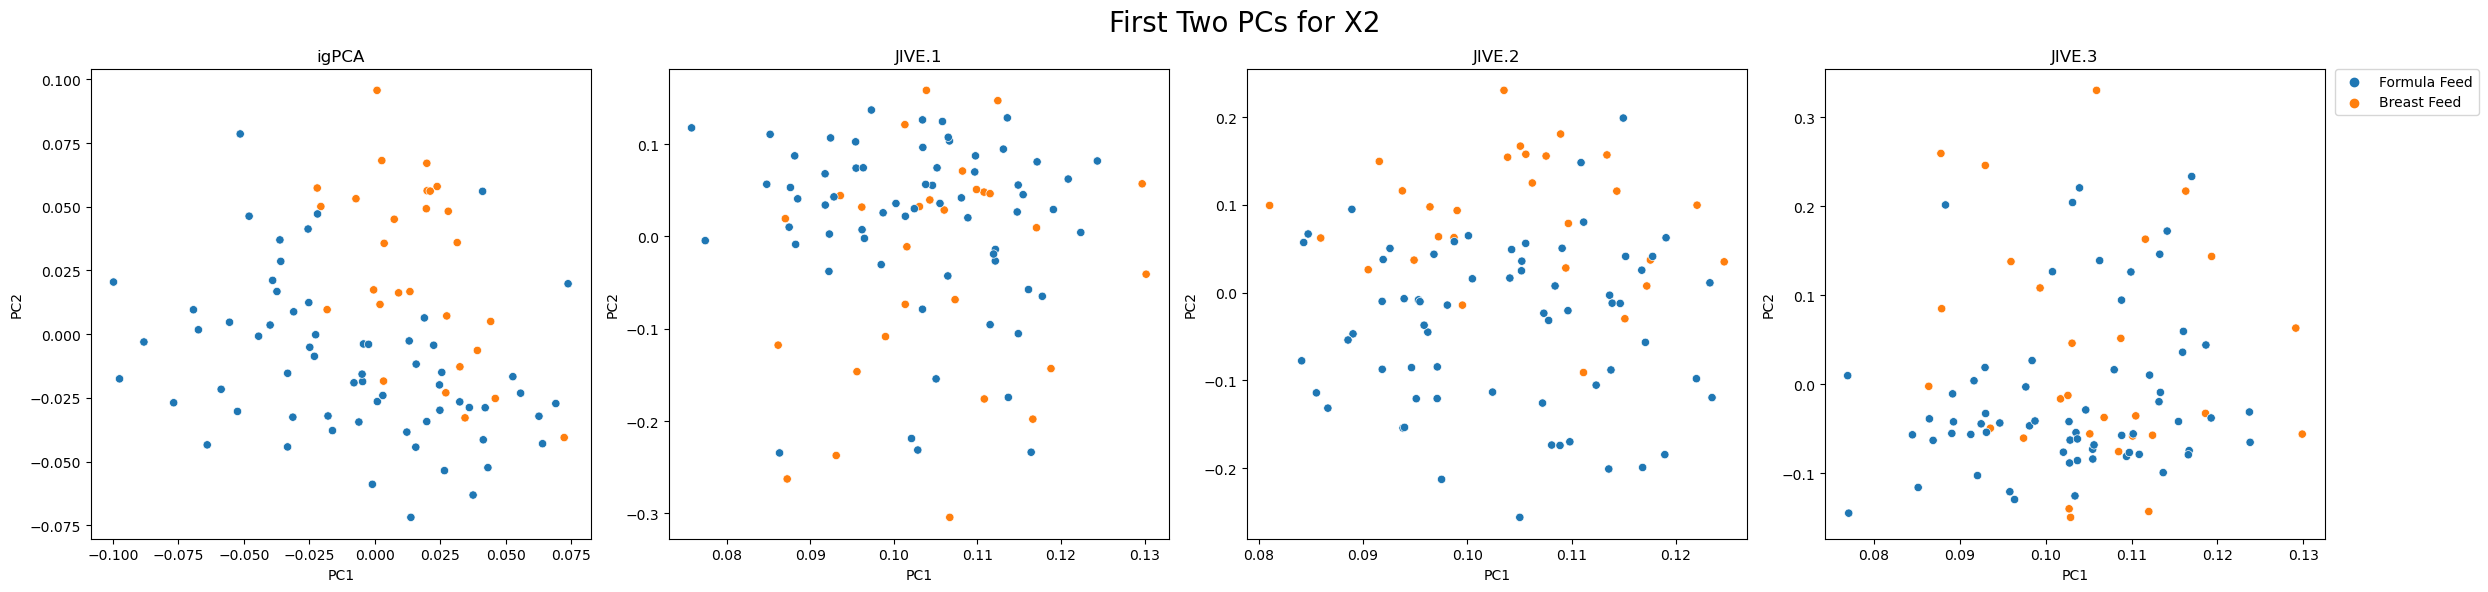

In [246]:
# first two PC of X1
fig, axes = plt.subplots(1, 4, figsize=(25, 6))
plt.tight_layout(h_pad=2)
sns.scatterplot(data=first_two_pc_x2(model1), x="PC1", y="PC2", hue = "diet", ax=axes[0])
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('igPCA')
axes[0].get_legend().set_visible(False)
sns.scatterplot(data=first_two_pc_x2(model2), x="PC1", y="PC2", hue = "diet", ax=axes[1])
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('JIVE.1')
axes[1].get_legend().set_visible(False)
sns.scatterplot(data=first_two_pc_x2(model3), x="PC1", y="PC2", hue = "diet", ax=axes[2])
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].set_title('JIVE.2')
axes[2].get_legend().set_visible(False)
sns.scatterplot(data=first_two_pc_x2(model4), x="PC1", y="PC2", hue = "diet", ax=axes[3])
axes[3].set_xlabel('PC1')
axes[3].set_ylabel('PC2')
axes[3].set_title('JIVE.3')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.suptitle("First Two PCs for X2", size = 20)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## Variable Loading: Microbiome

In [247]:
def first_two_vl(model):
    score = np.concatenate([var_ingredient_x1(model)[4][:,0:1], var_ingredient_x1(model)[4][:,1:2]], axis=1)
    to_plot = pd.DataFrame(score, columns = ['VL1','VL2'], index = taxa.index)
    to_plot = pd.concat([to_plot, taxa], axis = 1)
    return(to_plot)

def first_two_joint_vl(model):
    if model.r0 == 1:
        score = model.V01[:,:1].reshape(-1,1)
        to_plot = pd.DataFrame(score, columns = ['VL1'], index = taxa.index)
    else:
        score = np.concatenate([model.V01[:,:1].reshape(-1,1), model.V01[:,1:2].reshape(-1,1)], axis=1)
        to_plot = pd.DataFrame(score, columns = ['VL1','VL2'], index = taxa.index)
    to_plot = pd.concat([to_plot, taxa], axis = 1)
    return(to_plot)

/var/folders/7j/nhzytlhx5qd4n0cz79hdk2zr0000gn/T/ipykernel_30137/2447849615.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


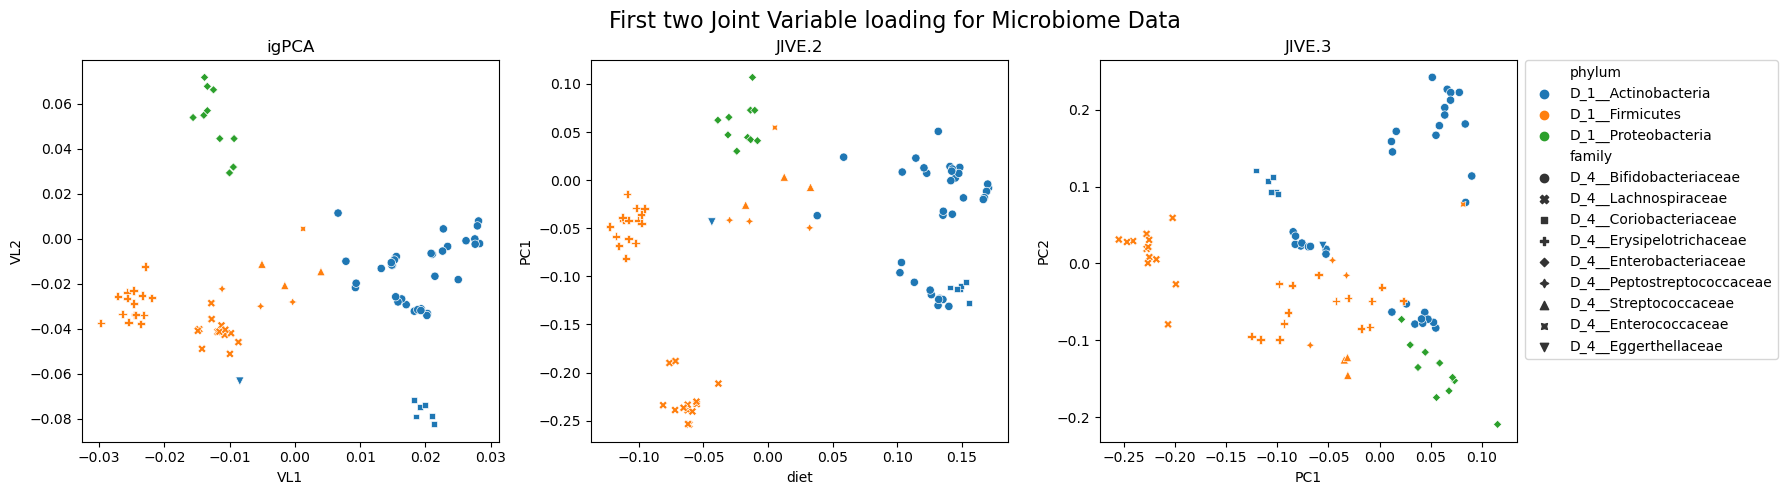

In [251]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.tight_layout(h_pad=2)
sns.scatterplot(data=first_two_joint_vl(model1), x="VL1", y="VL2", hue = "phylum",style = 'family', ax=axes[0])
axes[0].set_xlabel('VL1')
axes[0].set_ylabel('VL2')
axes[0].set_title('igPCA')
axes[0].get_legend().set_visible(False)
sns.scatterplot(data=first_two_joint_vl(model3), x="VL1", y="VL2", hue = "phylum", style = 'family', ax=axes[1])
axes[1].set_xlabel('diet')
axes[1].set_ylabel('PC1')
axes[1].set_title('JIVE.2')
axes[1].get_legend().set_visible(False)
sns.scatterplot(data=first_two_joint_vl(model4), x="VL1", y="VL2", hue = "phylum", style = 'family', ax=axes[2])
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].set_title('JIVE.3')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.suptitle("First two Joint Variable loading for Microbiome Data", size = 16)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

/var/folders/7j/nhzytlhx5qd4n0cz79hdk2zr0000gn/T/ipykernel_30137/3841976810.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


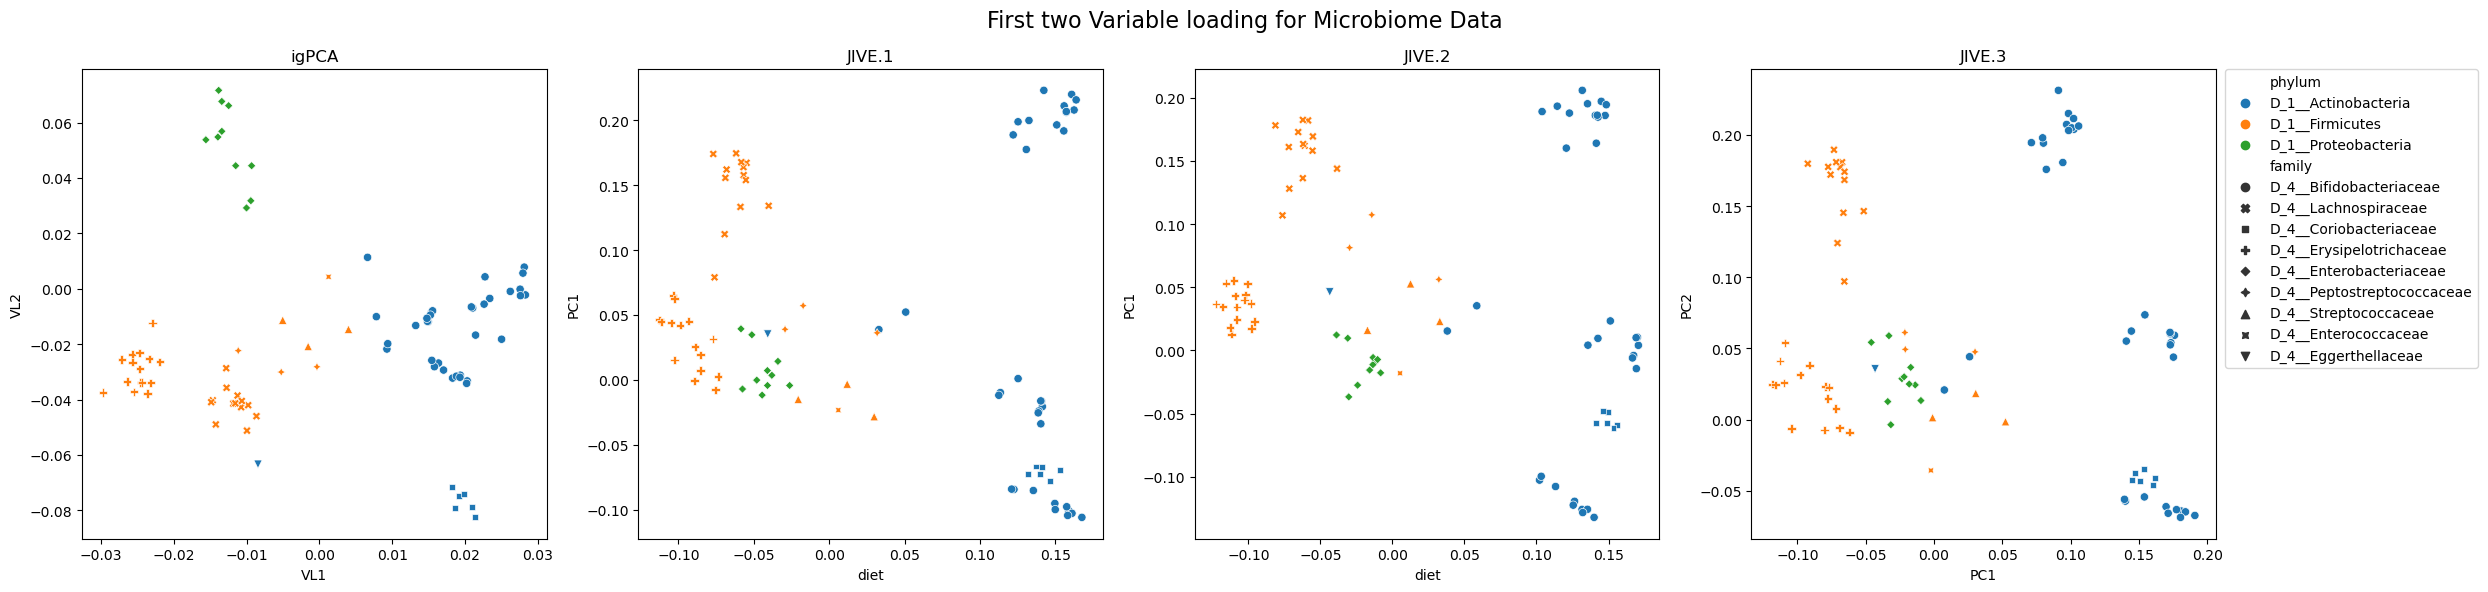

In [253]:
fig, axes = plt.subplots(1, 4, figsize=(25, 6))
plt.tight_layout(h_pad=2)
sns.scatterplot(data=first_two_vl(model1), x="VL1", y="VL2", hue = "phylum", style = 'family', ax=axes[0])
axes[0].set_xlabel('VL1')
axes[0].set_ylabel('VL2')
axes[0].set_title('igPCA')
axes[0].get_legend().set_visible(False)
sns.scatterplot(data=first_two_vl(model2), x="VL1", y="VL2", hue = "phylum", style = 'family', ax=axes[1])
axes[1].set_xlabel('diet')
axes[1].set_ylabel('PC1')
axes[1].set_title('JIVE.1')
axes[1].get_legend().set_visible(False)
sns.scatterplot(data=first_two_vl(model3), x="VL1", y="VL2", hue = "phylum", style = 'family', ax=axes[2])
axes[2].set_xlabel('diet')
axes[2].set_ylabel('PC1')
axes[2].set_title('JIVE.2')
axes[2].get_legend().set_visible(False)
sns.scatterplot(data=first_two_vl(model4), x="VL1", y="VL2", hue = "phylum", style = 'family', ax=axes[3])
axes[3].set_xlabel('PC1')
axes[3].set_ylabel('PC2')
axes[3].set_title('JIVE.3')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.suptitle("First two Variable loading for Microbiome Data", size = 16)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## Variable Loading: Metabolomic

In [ ]:
# def first_two_vl_meta(model):
#     score = np.concatenate([var_ingredient_x2(model)[4][:,0:1], var_ingredient_x2(model)[4][:,1:2]], axis=1)
#     to_plot = pd.DataFrame(score, columns = ['VL1','VL2'], index = taxa.index)
#     to_plot = pd.concat([to_plot, taxa], axis = 1)
#     return(to_plot)

# def first_two_joint_meta(model):
#     if model.r0 == 1:
#         score = model.V01[:,:1].reshape(-1,1)
#         to_plot = pd.DataFrame(score, columns = ['VL1'], index = taxa.index)
#     else:
#         score = np.concatenate([model.V01[:,:1].reshape(-1,1), model.V01[:,1:2].reshape(-1,1)], axis=1)
#         to_plot = pd.DataFrame(score, columns = ['VL1','VL2'], index = taxa.index)
#     to_plot = pd.concat([to_plot, taxa], axis = 1)
#     return(to_plot)

# Prediction Performance

In [257]:
# helper functions for prediction evaluation
y = np.multiply(description["classification"].values == 'Breast Feed',1)
clf = RandomForestClassifier(max_depth=None, random_state=0, oob_score = True)

def prediction_joint(model, N):
    X = (model.U0).reshape(-1,model.r0)
    if model.r0 >1 :
        result = np.zeros((N, 2, 3))
        for k in range(N):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=k)
            for i in range(1, 3):
                clf.fit(X_train[:,:i], y_train)
                result[k,i-1,0] = f1_score(y_test, clf.predict(X_test[:,:i]),average=None)[0]
                fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict(X_test[:,:i]), pos_label = 1)
                result[k,i-1,1] = metrics.auc(fpr, tpr)
                result[k, i-1,2] = 1 - clf.oob_score_
        return((np.mean(result, axis = 0), np.std(result, axis = 0)))
    else:
        for k in range(N):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=k)
            result = np.zeros((N, 1, 3))
            clf.fit(X_train[:,:1], y_train)
            result[k,0,0] = f1_score(y_test, clf.predict(X_test[:,:1]),average=None)[0]
            fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict(X_test[:,:1]), pos_label = 1)
            result[k,0,1] = metrics.auc(fpr, tpr)
            result[k, 0,2] = 1 - clf.oob_score_
        return((np.mean(result, axis = 0), np.std(result, axis = 0)))

def prediction_x1(model, N):
    try:
        rank = model.r1
        X = var_ingredient_x1(model)[3].reshape(-1,model1.r1)
    except AttributeError:
        rank = model.K
        X = (model.U).reshape(-1,model.K)
    result = np.zeros((N, 2, 3))
    for k in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=k)
        for i in range(1, 3):
            clf.fit(X_train[:,:i], y_train)
            result[k,i-1,0] = f1_score(y_test, clf.predict(X_test[:,:i]),average=None)[0]
            fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict(X_test[:,:i]), pos_label = 1)
            result[k,i-1,1] = metrics.auc(fpr, tpr)
            result[k,i-1,2] = 1 - clf.oob_score_
    return((np.mean(result, axis = 0), np.std(result, axis = 0)))


def prediction_x2(model, N):
    try:
        rank = model.r2
        X = var_ingredient_x2(model)[3].reshape(-1,model1.r2)
    except AttributeError:
        rank = model.K
        X = (model.U).reshape(-1,model.K)
    result = np.zeros((N, 2, 3))
    for k in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=k)
        for i in range(1, 3):
            clf.fit(X_train[:,:i], y_train)
            result[k,i-1,0] = f1_score(y_test, clf.predict(X_test[:,:i]),average=None)[0]
            fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict(X_test[:,:i]), pos_label = 1)
            result[k,i-1,1] = metrics.auc(fpr, tpr)
            result[k,i-1,2] = 1 - clf.oob_score_
    return((np.mean(result, axis = 0), np.std(result, axis = 0)))

In [165]:
# joint
igpca_joint = prediction_joint(model1, 100)
jive1_joint = prediction_joint(model2, 100)
jive2_joint = prediction_joint(model3, 100)
jive3_joint = prediction_joint(model4, 100)

In [170]:
# X1
igpca_1 = prediction_x1(model1, 100)
jive1_1 = prediction_x1(model2, 100)
jive2_1= prediction_x1(model3, 100)
jive3_1= prediction_x1(model4, 100)
gmd_1 = prediction_x1(model5, 100)

In [171]:
# X2
igpca_2 = prediction_x2(model1, 100)
jive1_2 = prediction_x2(model2, 100)
jive2_2 = prediction_x2(model3, 100)
jive3_2= prediction_x1(model4, 100)
gmd_2 = prediction_x2(model6, 100)

/var/folders/7j/nhzytlhx5qd4n0cz79hdk2zr0000gn/T/ipykernel_30137/3487159393.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


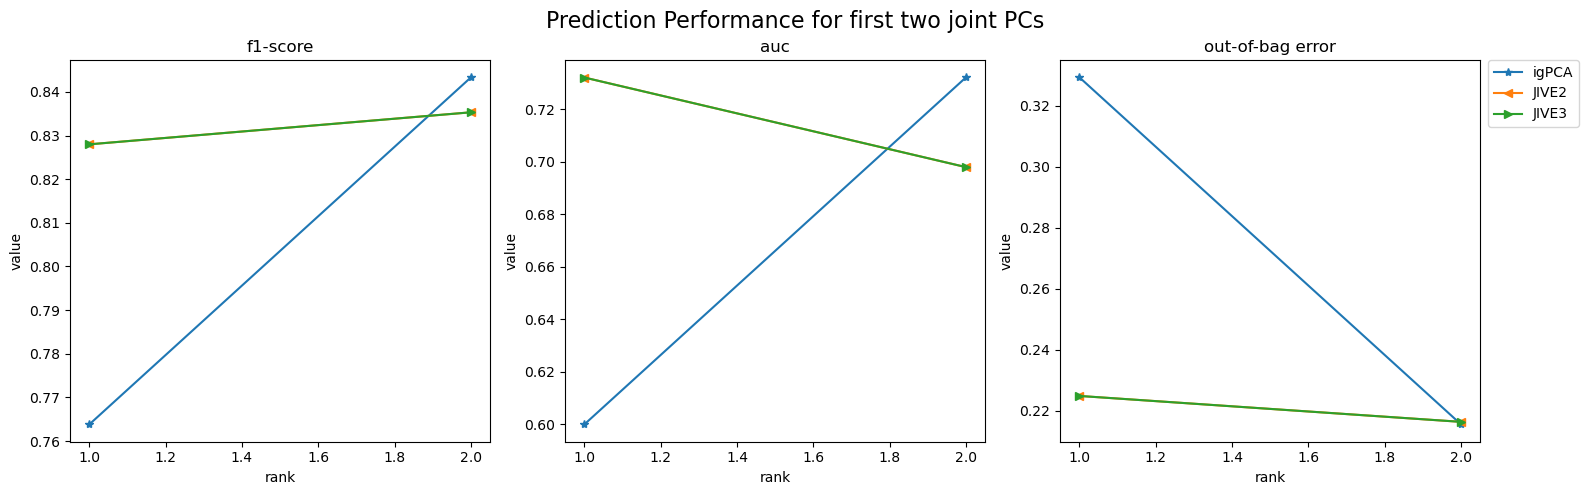

In [211]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
plt.tight_layout(h_pad=2)
axes[0].plot(np.arange(1,3), igpca_joint[0][:,0], '*-' ,label = 'igPCA')
axes[0].plot(np.arange(1,3), jive2_joint[0][:,0], '<-', label = 'JIVE2')
axes[0].plot(np.arange(1,3), jive3_joint[0][:,0], '>-', label = 'JIVE3')
axes[0].set_xlabel('rank')
axes[0].set_ylabel('value')
axes[0].set_title('f1-score')
axes[1].plot(np.arange(1,3), igpca_joint[0][:,1], '*-', label = 'igPCA')
axes[1].plot(np.arange(1,3), jive2_joint[0][:,1], '<-',label = 'JIVE2')
axes[1].plot(np.arange(1,3), jive3_joint[0][:,1], '>-',label = 'JIVE3')
axes[1].set_xlabel('rank')
axes[1].set_ylabel('value')
axes[1].set_title('auc')
axes[2].plot(np.arange(1,3), igpca_joint[0][:,2], '*-', label = 'igPCA')
axes[2].plot(np.arange(1,3), jive2_joint[0][:,2],  '<-',label = 'JIVE2')
axes[2].plot(np.arange(1,3), jive3_joint[0][:,2],  '>-',label = 'JIVE3')
axes[2].set_xlabel('rank')
axes[2].set_ylabel('value')
axes[2].set_title('out-of-bag error')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.suptitle("Prediction Performance for first two joint PCs", size = 16)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

/var/folders/7j/nhzytlhx5qd4n0cz79hdk2zr0000gn/T/ipykernel_30137/955130397.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


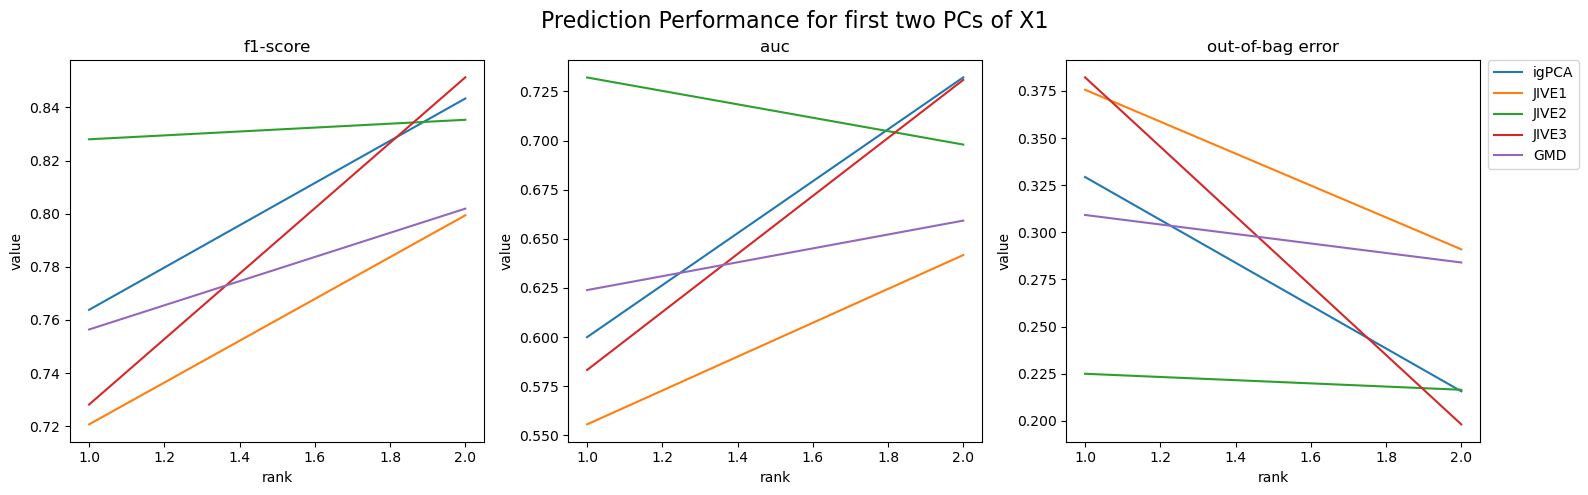

In [212]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
plt.tight_layout(h_pad=2)
axes[0].plot(np.arange(1,3), igpca_1[0][:,0], label = 'igPCA')
axes[0].plot(np.arange(1,3), jive1_1[0][:,0],  label = 'JIVE1')
axes[0].plot(np.arange(1,3), jive2_1[0][:,0],  label = 'JIVE2')
axes[0].plot(np.arange(1,3), jive3_1[0][:,0],  label = 'JIVE3')
axes[0].plot(np.arange(1,3),gmd_1[0][:,0], label = 'GMD')
axes[0].set_xlabel('rank')
axes[0].set_ylabel('value')
axes[0].set_title('f1-score')
axes[1].plot(np.arange(1,3), igpca_1[0][:,1], label = 'igPCA')
axes[1].plot(np.arange(1,3), jive1_1[0][:,1],  label = 'JIVE1')
axes[1].plot(np.arange(1,3), jive2_1[0][:,1],  label = 'JIVE2')
axes[1].plot(np.arange(1,3), jive3_1[0][:,1],  label = 'JIVE3')
axes[1].plot(np.arange(1,3),gmd_1[0][:,1], label = 'GMD')
axes[1].set_xlabel('rank')
axes[1].set_ylabel('value')
axes[1].set_title('auc')
axes[2].plot(np.arange(1,3), igpca_1[0][:,2], label = 'igPCA')
axes[2].plot(np.arange(1,3), jive1_1[0][:,2],  label = 'JIVE1')
axes[2].plot(np.arange(1,3), jive2_1[0][:,2],  label = 'JIVE2')
axes[2].plot(np.arange(1,3), jive3_1[0][:,2],  label = 'JIVE3')
axes[2].plot(np.arange(1,3),gmd_1[0][:,2], label = 'GMD')
axes[2].set_xlabel('rank')
axes[2].set_ylabel('value')
axes[2].set_title('out-of-bag error')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.suptitle("Prediction Performance for first two PCs of X1", size = 16)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

/var/folders/7j/nhzytlhx5qd4n0cz79hdk2zr0000gn/T/ipykernel_30137/4283766548.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


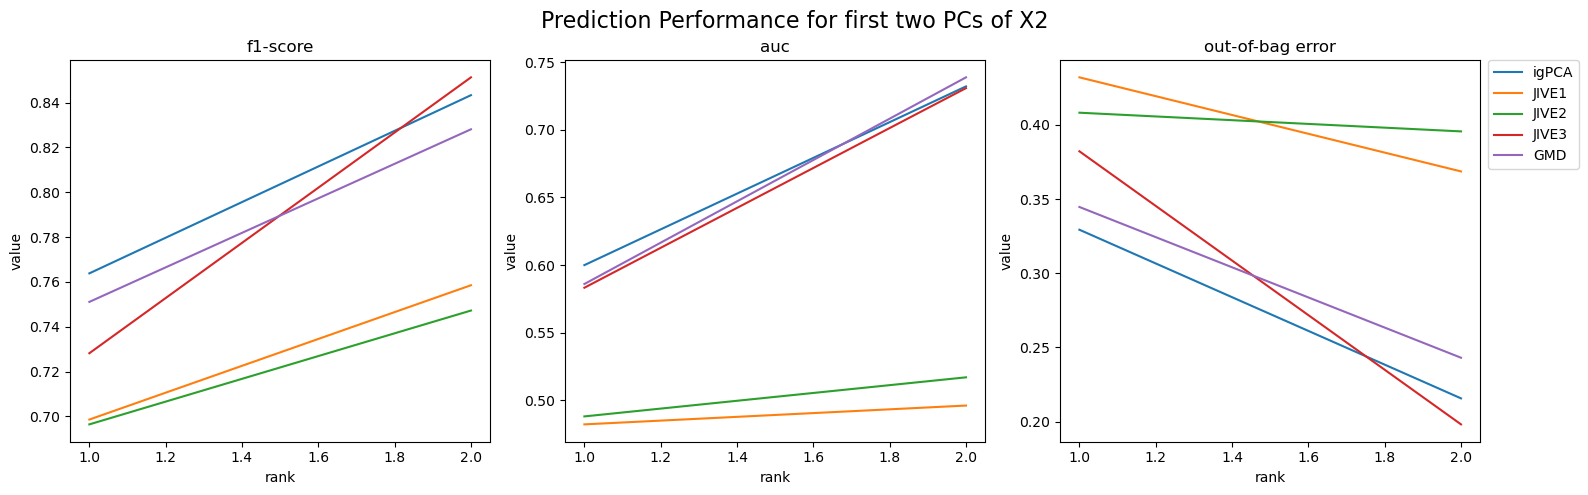

In [213]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
plt.tight_layout(h_pad=2)
axes[0].plot(np.arange(1,3), igpca_2[0][:,0], label = 'igPCA')
axes[0].plot(np.arange(1,3), jive1_2[0][:,0],  label = 'JIVE1')
axes[0].plot(np.arange(1,3), jive2_2[0][:,0],  label = 'JIVE2')
axes[0].plot(np.arange(1,3), jive3_2[0][:,0],  label = 'JIVE3')
axes[0].plot(np.arange(1,3), gmd_2[0][:,0], label = 'GMD')
axes[0].set_xlabel('rank')
axes[0].set_ylabel('value')
axes[0].set_title('f1-score')
axes[1].plot(np.arange(1,3), igpca_2[0][:,1], label = 'igPCA')
axes[1].plot(np.arange(1,3), jive1_2[0][:,1],  label = 'JIVE1')
axes[1].plot(np.arange(1,3), jive2_2[0][:,1],  label = 'JIVE2')
axes[1].plot(np.arange(1,3), jive3_2[0][:,1],  label = 'JIVE3')
axes[1].plot(np.arange(1,3),gmd_2[0][:,1], label = 'GMD')
axes[1].set_xlabel('rank')
axes[1].set_ylabel('value')
axes[1].set_title('auc')
axes[2].plot(np.arange(1,3), igpca_2[0][:,2], label = 'igPCA')
axes[2].plot(np.arange(1,3), jive1_2[0][:,2],  label = 'JIVE1')
axes[2].plot(np.arange(1,3), jive2_2[0][:,2],  label = 'JIVE2')
axes[2].plot(np.arange(1,3), jive3_2[0][:,2],  label = 'JIVE3')
axes[2].plot(np.arange(1,3),gmd_2[0][:,2], label = 'GMD')
axes[2].set_xlabel('rank')
axes[2].set_ylabel('value')
axes[2].set_title('out-of-bag error')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.suptitle("Prediction Performance for first two PCs of X2", size = 16)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

### Numerical Results

In [442]:
def table_by_metric(index):
    x1_mean = np.array((igpca_1[0][1,index], jive1_1[0][1,index], jive2_1[0][1,index], jive3_1[0][1,index],  gmd_1[0][1,index]))
    x2_mean = np.array((igpca_2[0][1,index], jive1_2[0][1,index], jive2_2[0][1,index], jive3_2[0][1,index],  gmd_2[0][1,index]))
    joint_mean = np.array((igpca_joint[0][1,index], jive1_joint[0][0,index], jive2_joint[0][1,index], jive3_joint[0][1,index], None))
    x1_std = np.array((igpca_1[1][1,index], jive1_1[1][1,index], jive2_1[1][1,index], jive3_1[1][1,index],  gmd_1[1][1,index]))
    x2_std = np.array((igpca_2[1][1,index], jive1_2[1][1,index], jive2_2[1][1,index], jive3_2[1][1,index],  gmd_2[1][1,index]))
    joint_std = np.array((igpca_joint[1][1,index], jive1_joint[1][0,index], jive2_joint[1][1,index], jive3_joint[1][1,index], None))
    tot = np.array((joint_mean, x1_mean, x2_mean, joint_std, x1_std, x2_std))
    tot = tot.reshape((2,15))
    return(tot)

In [444]:
B = np.array(['mean', 'std'])

In [445]:
f1 = pd.DataFrame(data=table_by_metric(0).T, columns=B)
f1['method'] = (['igPCA']+ ['JIVE1']+ ['JIVE2']+ ['JIVE3']+ ['GMD'])*3
f1['matrix'] =  ['joint']*5 + ['X1']*5 +  ['X2']*5 

In [446]:
auc = pd.DataFrame(data=table_by_metric(1).T, columns=pd.MultiIndex.from_tuples(zip(A,B)))
auc['method'] = (['igPCA']+ ['JIVE1']+ ['JIVE2']+ ['JIVE3']+ ['GMD'])*3
auc['matrix'] = ['joint']*5 + ['X1']*5 +  ['X2']*5 

In [447]:
oob = pd.DataFrame(data=table_by_metric(2).T, columns=pd.MultiIndex.from_tuples(zip(A,B)))
oob['method'] = (['igPCA']+ ['JIVE1']+ ['JIVE2']+ ['JIVE3']+ ['GMD'])*3
oob['matrix'] = ['joint']*5 + ['X1']*5 +  ['X2']*5 

In [448]:
f1.pivot(index='method', columns='matrix')

mean                           std                    
matrix        X1        X2     joint        X1        X2     joint
method                                                            
GMD      0.80189  0.828113      None  0.082665  0.075808      None
JIVE1   0.799379  0.758509     0.075  0.078137  0.076882     0.225
JIVE2    0.83533  0.747218  0.859082   0.06548  0.077613  0.050919
JIVE3   0.851298  0.851298   0.83533  0.068214  0.068214   0.06548
igPCA   0.843338  0.843338  0.843338  0.065494  0.065494  0.065494

In [449]:
auc.pivot(index='method', columns='matrix')

X1                            X2                    
            mean                           std                    
matrix        X1        X2     joint        X1        X2     joint
method                                                            
GMD     0.659263  0.738846      None  0.105942  0.112318      None
JIVE1   0.641734  0.496088  0.067949  0.114684  0.083537  0.203846
JIVE2   0.697953  0.516965  0.765454  0.099354  0.087984  0.068197
JIVE3   0.730873  0.730873  0.697953   0.10012   0.10012  0.099354
igPCA   0.732155  0.732155  0.732155  0.103696  0.103696  0.103696

In [450]:
oob.pivot(index='method', columns='matrix')

X1                            X2                    
            mean                           std                    
matrix        X1        X2     joint        X1        X2     joint
method                                                            
GMD     0.283973  0.243014      None  0.043052  0.036891      None
JIVE1   0.290959   0.36863  0.026027  0.042049  0.045684  0.078082
JIVE2   0.216438  0.395616  0.234247  0.033722  0.048905  0.031507
JIVE3   0.198082  0.198082  0.216438  0.031143  0.031143  0.033722
igPCA   0.215616  0.215616  0.215616    0.0394    0.0394    0.0394